## Fitting a Model to Data<sup>[1](https://andycasey.github.io/teaching/phs5000/1/),[2](https://andycasey.github.io/teaching/phs5000/2/),[3](https://andycasey.github.io/teaching/phs5000/3/)</sup>

In [1]:
# Preamble
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import emcee as mc
import matplotlib as mpl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scipy.optimize as op

from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["olivedrab", "steelblue", "firebrick", "goldenrod"]) 
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True

N = 2**8

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(107/256, 1, N)
vals[:, 1] = np.linspace(142/256, 1, N)
vals[:, 2] = np.linspace(35/256, 1, N)

OliveDrab = ListedColormap(vals)
OliveDrab_r = OliveDrab.reversed()

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(70/256, 1, N)
vals[:, 1] = np.linspace(130/256, 1, N)
vals[:, 2] = np.linspace(180/256, 1, N)

SteelBlue = ListedColormap(vals)
SteelBlue_r = SteelBlue.reversed()

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(178/256, 1, N)
vals[:, 1] = np.linspace(34/256, 1, N)
vals[:, 2] = np.linspace(34/256, 1, N)

FireBrick = ListedColormap(vals)
FireBrick_r = FireBrick.reversed()

vals = np.ones((N, 4))
vals[:, 0] = np.linspace(218/256, 1, N)
vals[:, 1] = np.linspace(165/256, 1, N)
vals[:, 2] = np.linspace(32/256, 1, N)

GoldenRod = ListedColormap(vals)
GoldenRod_r = GoldenRod.reversed()

In [2]:
# Reproducability
rng = np.random.default_rng(0)

# Data
_, x, y, y_err, x_err, rho_xy = data = np.array([
    [1,  201, 592, 61,  9, -0.84],
    [2,  244, 401, 25,  4, +0.31],
    [3,   47, 583, 38, 11, +0.64],
    [4,  287, 402, 15,  7, -0.27],
    [5,  203, 495, 21,  5, -0.33],
    [6,   58, 173, 15,  9, +0.67],
    [7,  210, 479, 27,  4, -0.02],
    [8,  202, 504, 14,  4, -0.05],
    [9,  198, 510, 30, 11, -0.84],
    [10, 158, 416, 16,  7, -0.69],
    [11, 165, 393, 14,  5, +0.30],
    [12, 201, 442, 25,  5, -0.46],
    [13, 157, 317, 52,  5, -0.03],
    [14, 131, 311, 16,  6, +0.50],
    [15, 166, 400, 34,  6, +0.73],
    [16, 160, 337, 31,  5, -0.52],
    [17, 186, 423, 42,  9, +0.90],
    [18, 125, 334, 26,  8, +0.40],
    [19, 218, 533, 16,  6, -0.78],
    [20, 146, 344, 22,  5, -0.56],
]).T

# Helper Function
def _ellipse(x, y, cov, scale=2, colors='k', **kwargs):
    vals, vecs = np.linalg.eig(cov)
    theta = np.degrees(np.arctan2(*vecs[::-1, 0]))
    w, h = scale * np.sqrt(vals)

    kwds = dict(lw=0.5, color=colors)
    kwds.update(**kwargs)

    ellipse = Ellipse(xy=[x, y], 
                      width=w, height=h, angle=theta,
                      **kwds)
    ellipse.set_facecolor("none")
    return ellipse

# Pretty Print
pd.DataFrame(data=(data.T)[:,1:], columns=[r'$x$', r'$y$', r'$\sigma_y$', r'$\sigma_x$', r'$\rho_{xy}$'])

,$x$,$y$,$\sigma_y$,$\sigma_x$,$\rho_{xy}$
0,201.0,592.0,61.0,9.0,-0.84
1,244.0,401.0,25.0,4.0,0.31
2,47.0,583.0,38.0,11.0,0.64
3,287.0,402.0,15.0,7.0,-0.27
4,203.0,495.0,21.0,5.0,-0.33
5,58.0,173.0,15.0,9.0,0.67
6,210.0,479.0,27.0,4.0,-0.02
7,202.0,504.0,14.0,4.0,-0.05
8,198.0,510.0,30.0,11.0,-0.84
9,158.0,416.0,16.0,7.0,-0.69


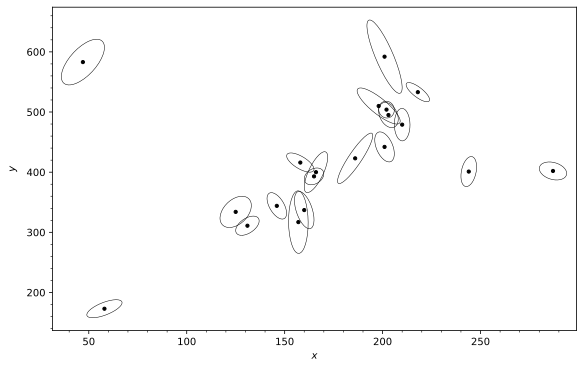

In [3]:
# Prepare Plot
covs = np.array([[[x_e**2, x_e*y_e*rho], [x_e*y_e*rho, y_e**2]] for y_e, x_e, rho in zip(*data[3:])])

fig, ax = plt.subplots()

for xi, yi, cov in zip(x, y, covs):
    ax.add_artist(_ellipse(xi, yi, cov))

ax.plot(x, y, 'k.', ms=6.42)

ax.set_ylabel(r'$y$')
ax.set_xlabel(r'$x$')

ax.yaxis.set_label_coords(-0.0675, 0.5)

ax.set_ylim(0.9 * ax.set_ylim()[0], 1.1 * ax.set_ylim()[1])
ax.set_xlim(0.9 * ax.set_xlim()[0], ax.set_xlim()[1])

plt.show()
plt.close()

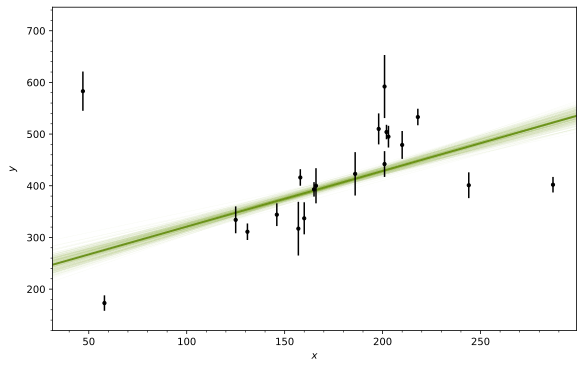

In [4]:
# Least Squares
Y = np.atleast_2d(y).T

A = np.vstack([np.ones_like(x), x]).T
C = np.diag(y_err * y_err)

C_inv = np.linalg.inv(C)

G = np.linalg.inv(A.T @ C_inv @ A)
X = G @ (A.T @ C_inv @ Y)

b, m = X.T[0]

# Prepare Plot
l = np.array([-100, 400])

fig, ax = plt.subplots()

ax.errorbar(x, y, yerr=y_err, fmt='k,')
ax.plot(x, y, 'k.', ms=6.42)

ax.set_ylabel(r'$y$')
ax.set_xlabel(r'$x$')

ax.yaxis.set_label_coords(-0.0675, 0.5)

ax.set_ylim(0.9 * ax.set_ylim()[0], 1.1 * ax.set_ylim()[1])
ax.set_xlim(0.9 * ax.set_xlim()[0], ax.set_xlim()[1])

ax.plot(l, m * l + b, lw=2, zorder=-1)

draws = rng.multivariate_normal(X.T[0], G, 256)
for b_, m_ in draws:
    ax.plot(l, l * m_ + b_, c="olivedrab", lw=0.5, zorder=-1, alpha=0.05)

plt.show()
plt.close()

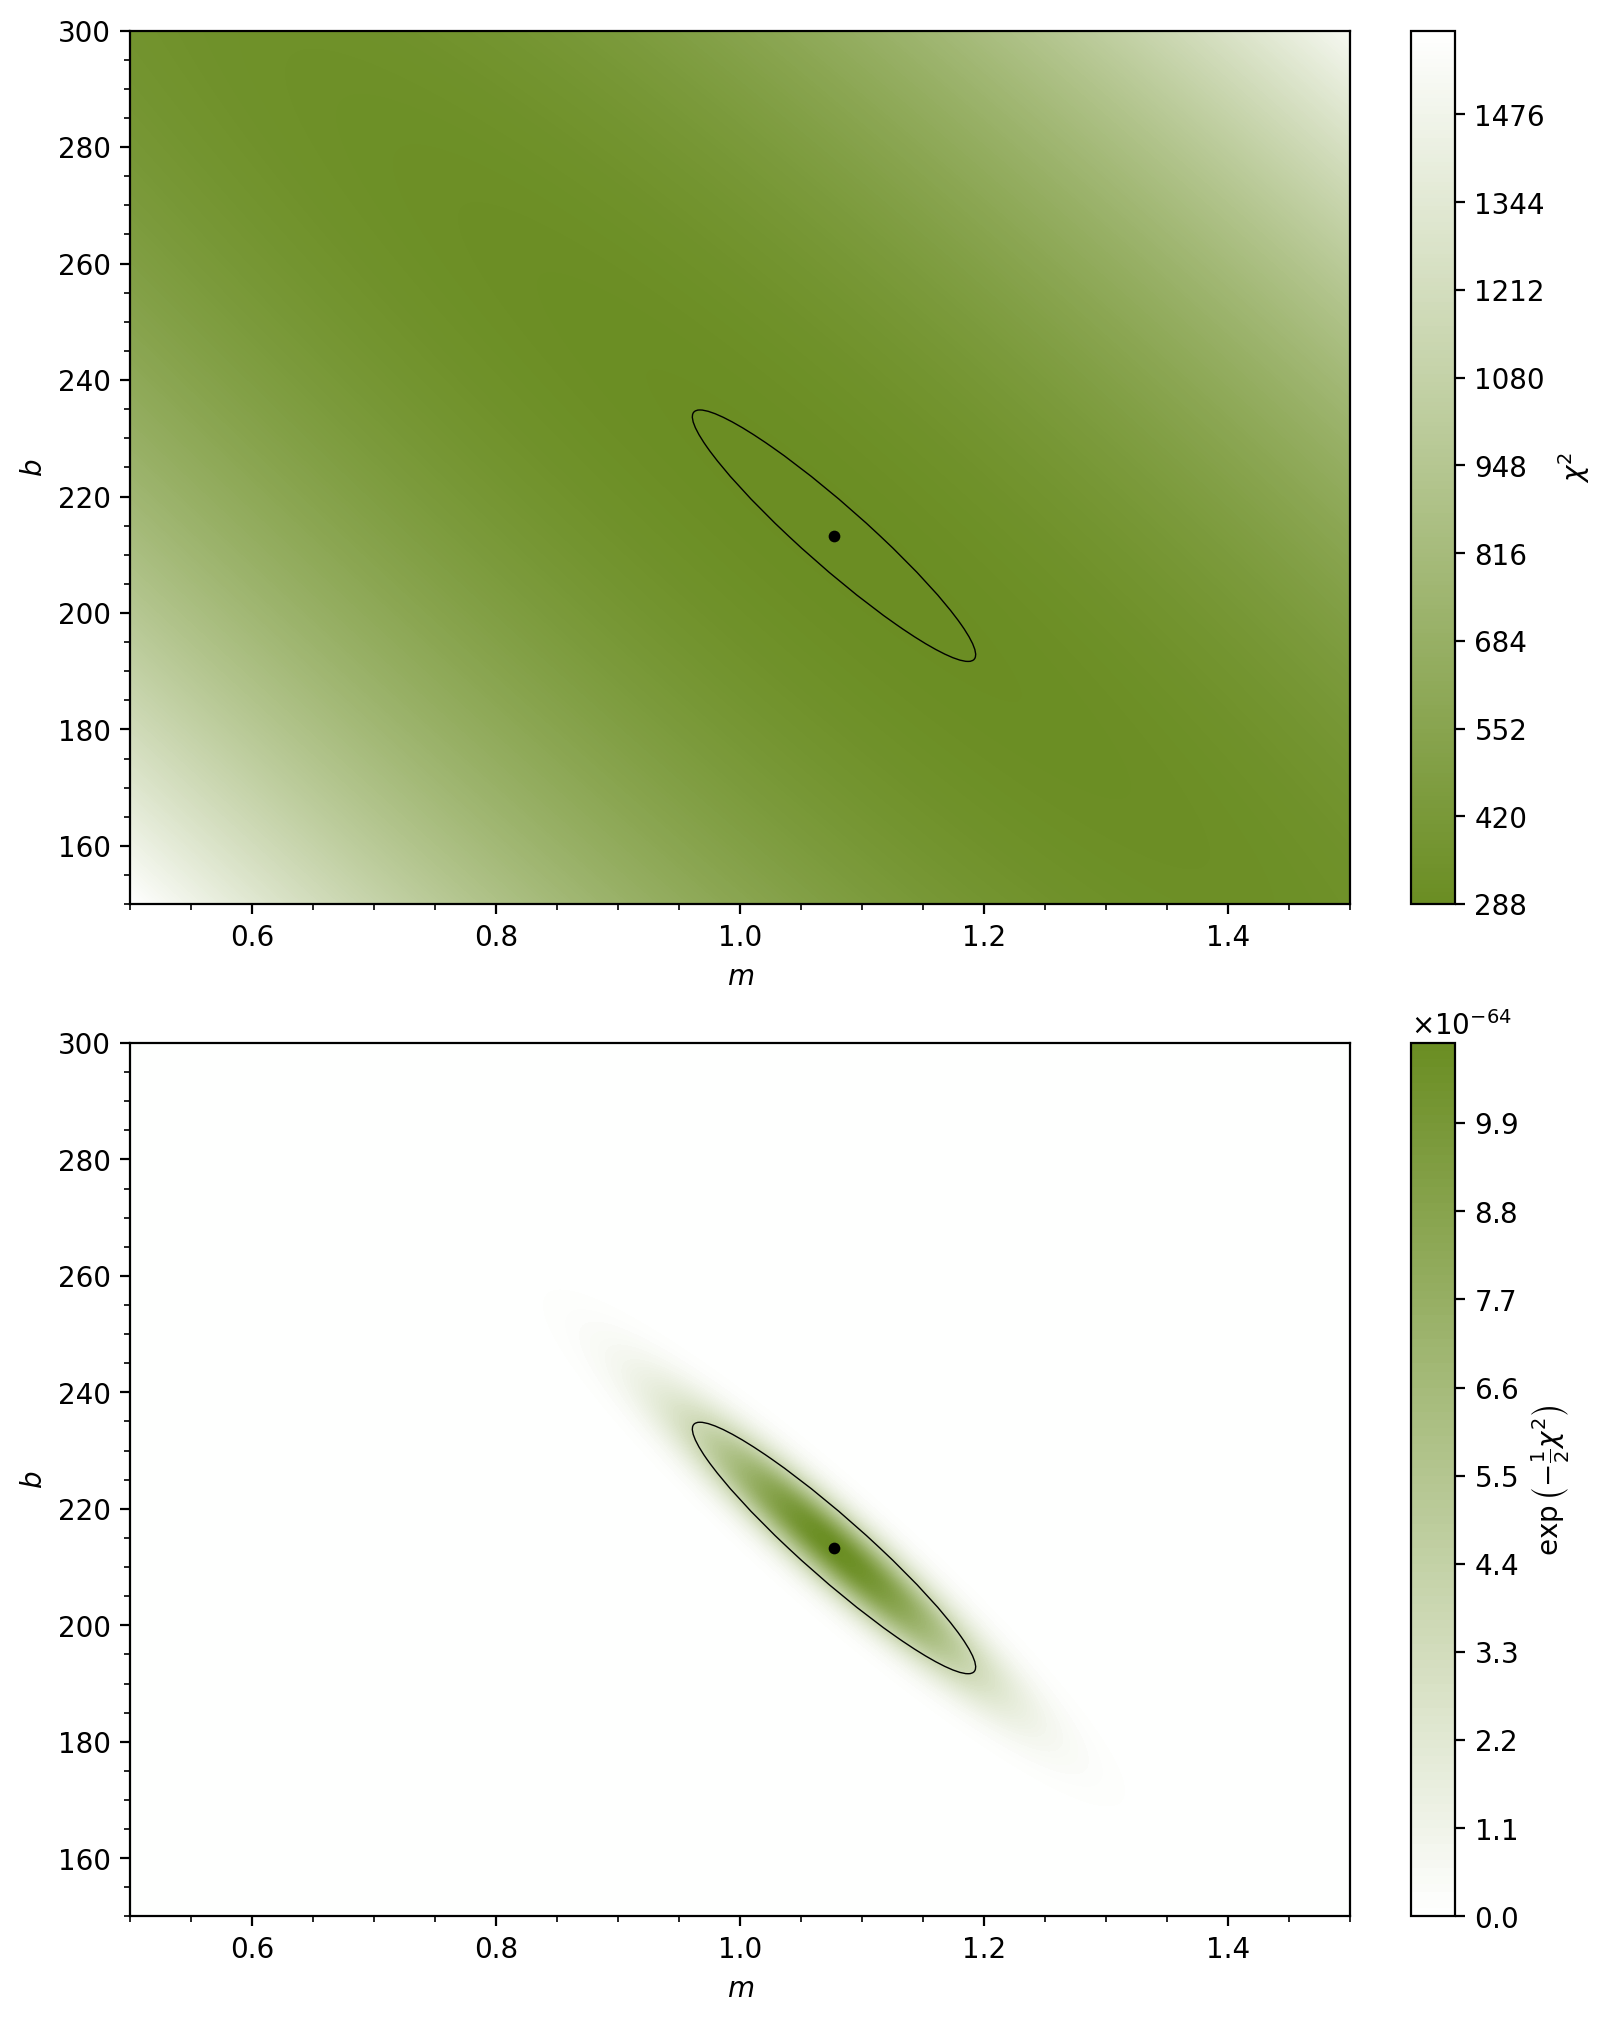

In [5]:
%config InlineBackend.figure_formats = ['retina']

# Parameter Space
bins = 512
m_bounds = (0.5, 1.5)
b_bounds = (150, 300)
    
m_bins = np.linspace(*m_bounds, bins)
b_bins = np.linspace(*b_bounds, bins)
    
M, B = np.meshgrid(m_bins, b_bins)
    
# Calculate Chi Squared
chi_sq = np.sum([(y_ - (M * x_ + B))**2 / y_err_**2 for (x_, y_, y_err_) in zip(x, y, y_err)], axis=0)

fig, ax = plt.subplots(2, 1, figsize=[8, 10])

cnt0 = ax[0].contourf(M, B, chi_sq, 256, cmap=OliveDrab)
cnt0.set_edgecolor("face")

cb0 = plt.colorbar(cnt0)
cb0.set_label(r"$\chi^2$")

ax[0].plot(X[1], X[0], 'k.', ms=6.42)
ax[0].add_artist(_ellipse(m, b, G[::-1, ::-1], scale=3))

ax[0].set_ylabel(r'$b$')
ax[0].set_xlabel(r'$m$')

ax[0].yaxis.set_label_coords(-0.0675, 0.5)

# Calculate Likelihood
like = np.exp(- chi_sq / 2)

cnt1 = ax[1].contourf(M, B, like, 128, cmap=OliveDrab_r)
cnt1.set_edgecolor("face")

cb1 = plt.colorbar(cnt1)
cb1.set_label(r"$\exp{\left(-\frac{1}{2}\chi^2\right)}$")
cb1.formatter.set_powerlimits((0, 0))
cb1.formatter.set_useMathText(True)
cb1.ax.yaxis.set_offset_position('left')

ax[1].plot(X[1], X[0], 'k.', ms=6.42)
ax[1].add_artist(_ellipse(m, b, G[::-1, ::-1], scale=3))

ax[1].set_ylabel(r'$b$')
ax[1].set_xlabel(r'$m$')

ax[1].yaxis.set_label_coords(-0.0675, 0.5)

plt.show()
plt.close()

%config InlineBackend.figure_formats = ['svg']

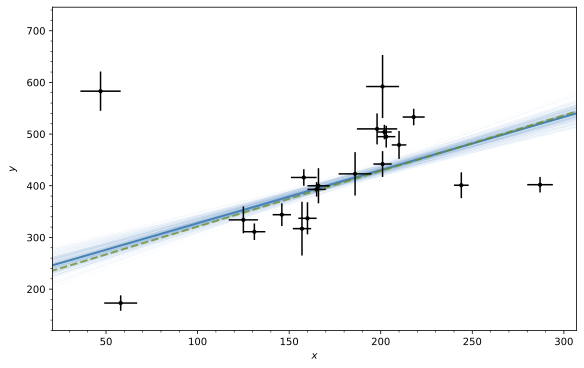

In [6]:
# Bayesian Minimization
xy_inv_var = 1 / (y_err**2 + x_err**2)

def ln_prior(theta):
    b, m = theta
    return -3/2 * np.log(1 + m**2)

def ln_likelihood(theta, x, y, xy_inv_var):
    b, m = theta
    return -1/2 * np.sum((y - m * x - b)**2 * xy_inv_var)

def ln_probability(theta, x, y, xy_inv_var):
    return ln_prior(theta) + ln_likelihood(theta, x, y, xy_inv_var)

neg_log_prob = lambda *args: -ln_probability(*args)

initial_theta = X.T[0]
args = (x, y, xy_inv_var)

result = op.minimize(neg_log_prob, initial_theta, args=args, method="L-BFGS-B")

# Prepare Plot
l = np.array([-100, 400])

fig, ax = plt.subplots()

ax.errorbar(x, y, yerr=y_err, xerr=x_err, fmt='k,')
ax.plot(x, y, 'k.', ms=6.42)

ax.set_ylabel(r'$y$')
ax.set_xlabel(r'$x$')

ax.yaxis.set_label_coords(-0.0675, 0.5)

ax.set_ylim(0.9 * ax.set_ylim()[0], 1.1 * ax.set_ylim()[1])
ax.set_xlim(0.9 * ax.set_xlim()[0], ax.set_xlim()[1])

ax.plot(l, initial_theta[1] * l + initial_theta[0], '--', alpha=0.75, lw=2, zorder=-1)
ax.plot(l, result.x[1] * l + result.x[0], lw=2, zorder=-2)

# Sample Distribution
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * rng.standard_normal(ndim) for k in range(nwalkers)]

sampler = mc.EnsembleSampler(nwalkers, ndim, ln_probability,args=args)

pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

sampler.run_mcmc(pos, 5000)

chain = sampler.chain.reshape((-1, ndim))

for index in rng.choice(chain.shape[0], size=256):
    b, m = chain[index]
    ax.plot(l, m * l + b, c="steelblue", alpha=0.05, lw=0.5, zorder=-3)

plt.show()
plt.close()

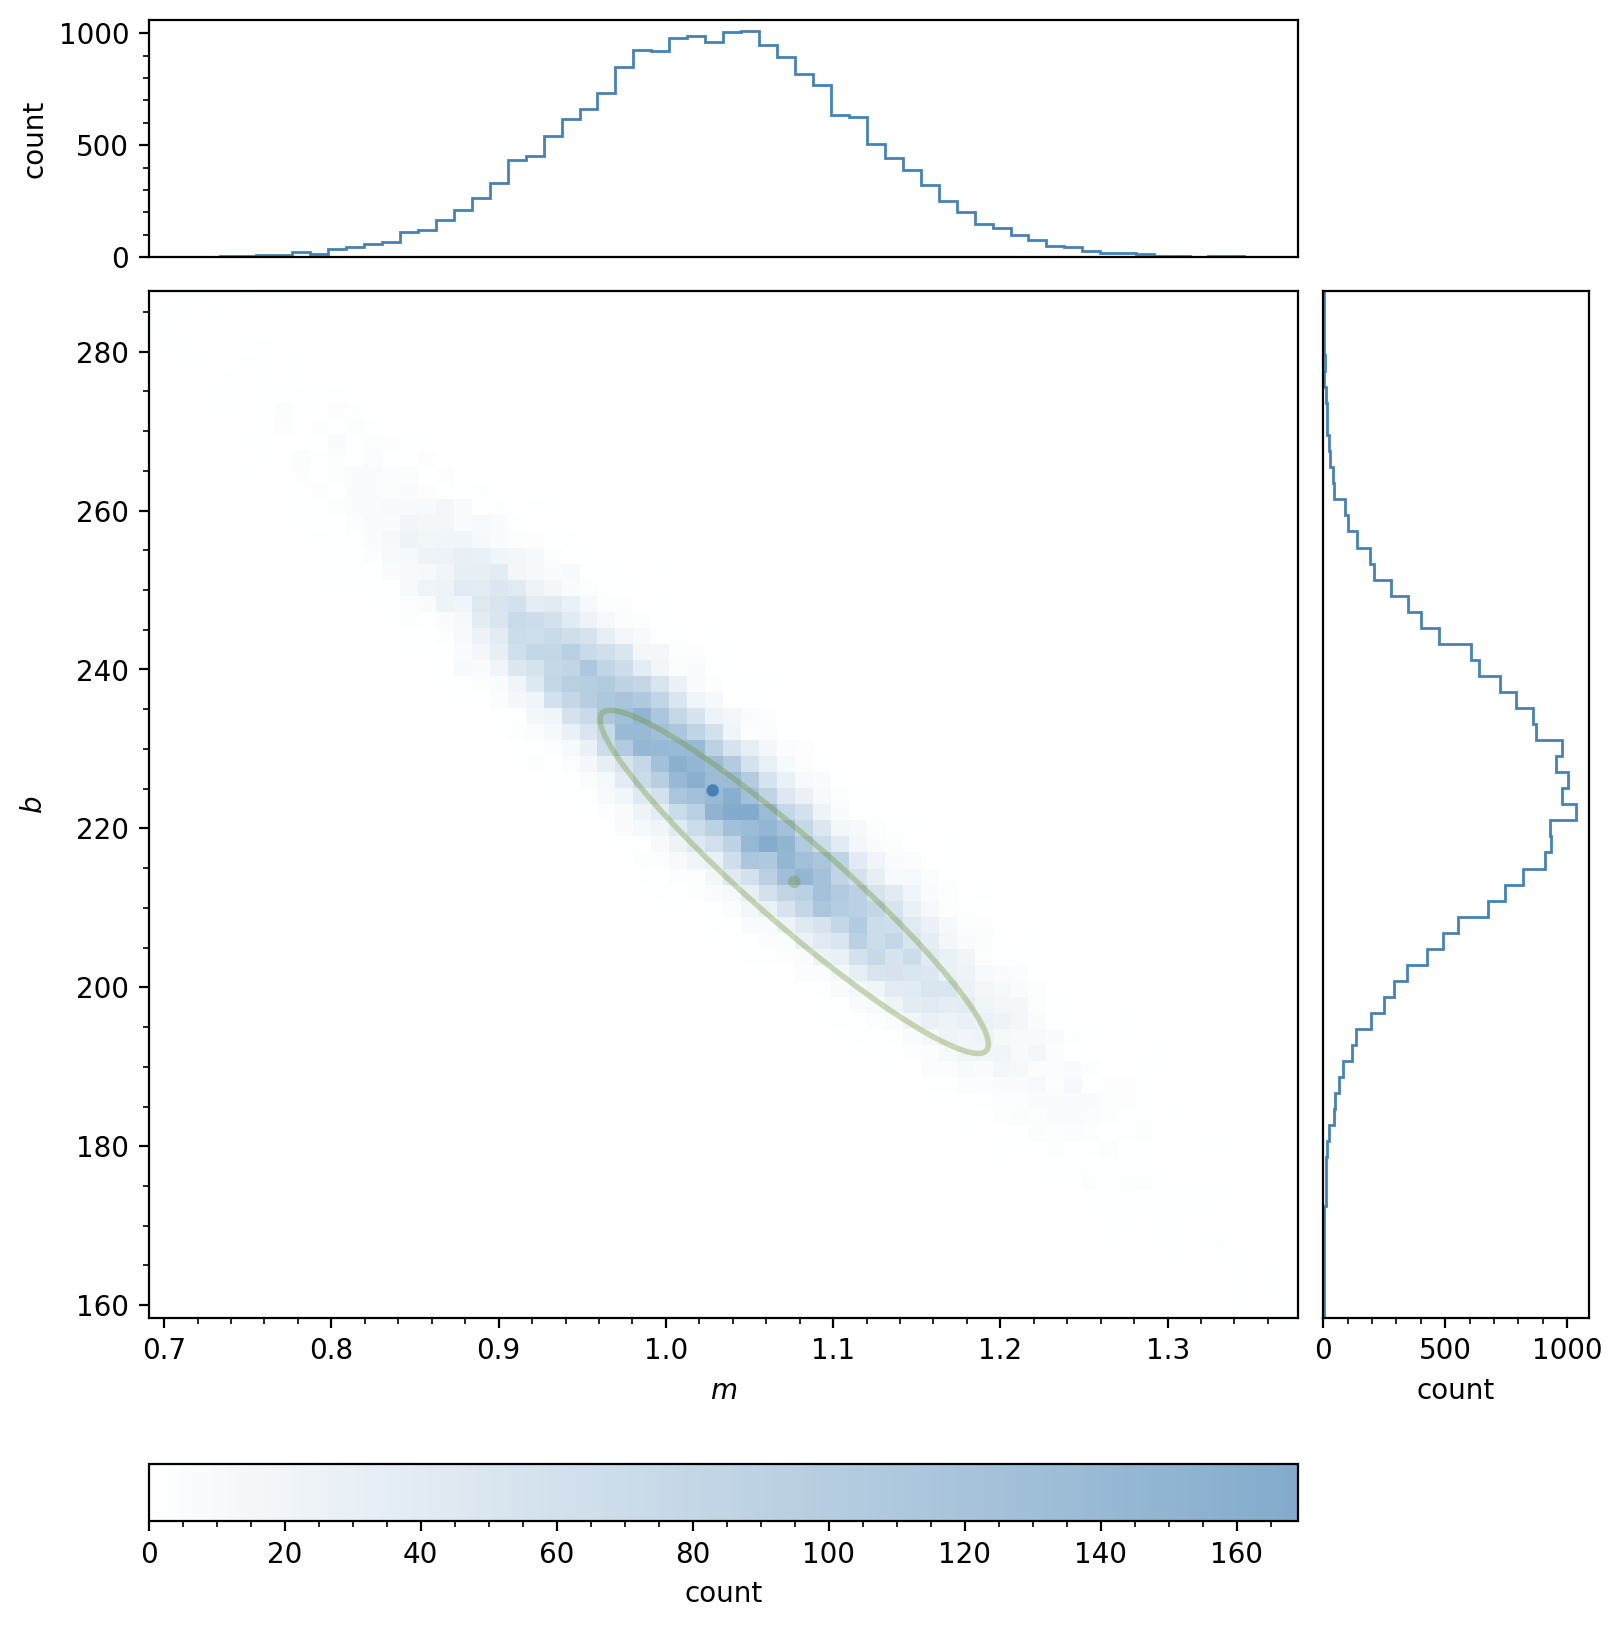

In [7]:
%config InlineBackend.figure_formats = ['retina']

# Main Plot
flat_samples = sampler.get_chain(thin=8, flat=True)

fig, ax = plt.subplots(2, 2, figsize=(8, 8), height_ratios=[1.5, 6.5], width_ratios=[6.5, 1.5])

hist = ax[1, 0].hist2d(flat_samples[:,1], flat_samples[:,0], bins=64, cmap=SteelBlue_r, alpha=2/3)

ax[1, 0].scatter(result.x[1], result.x[0], 20, marker='o', facecolor="steelblue", edgecolor="none")

ax[1, 0].scatter(X[1], X[0], 20, marker='o', facecolor="olivedrab", edgecolor="none", alpha=1/3)
ax[1, 0].add_artist(_ellipse(X[1], X[0], G[::-1, ::-1], scale=3, color="olivedrab", lw=2, alpha=1/3))

cb = plt.colorbar(hist[3], location='bottom')
cb.set_label("count")

ax[1, 0].set_ylabel(r'$b$')
ax[1, 0].set_xlabel(r'$m$')

ax[1, 0].yaxis.set_label_coords(-0.0875, 0.5)

xlim = ax[1, 0].set_xlim()
ylim = ax[1, 0].set_ylim()

# Hidden Plot
ax[0, 1].axis('off')

# Top Plot
ax[0, 0].hist(flat_samples[:,1], bins=64, histtype='step', color="steelblue")

ax[0, 0].set_xlim(xlim)
ax[0, 0].get_xaxis().set_ticks([])

ax[0, 0].set_ylabel("count")
ax[0, 0].yaxis.set_label_coords(-0.0875, 0.5)

# Right Plot
ax[1, 1].hist(flat_samples[:,0], bins=64, histtype='step', orientation="horizontal", color="steelblue")

ax[1, 1].set_ylim(ylim)
ax[1, 1].get_yaxis().set_ticks([])

ax[1, 1].set_xlabel("count")

plt.show()
plt.close()

%config InlineBackend.figure_formats = ['svg']

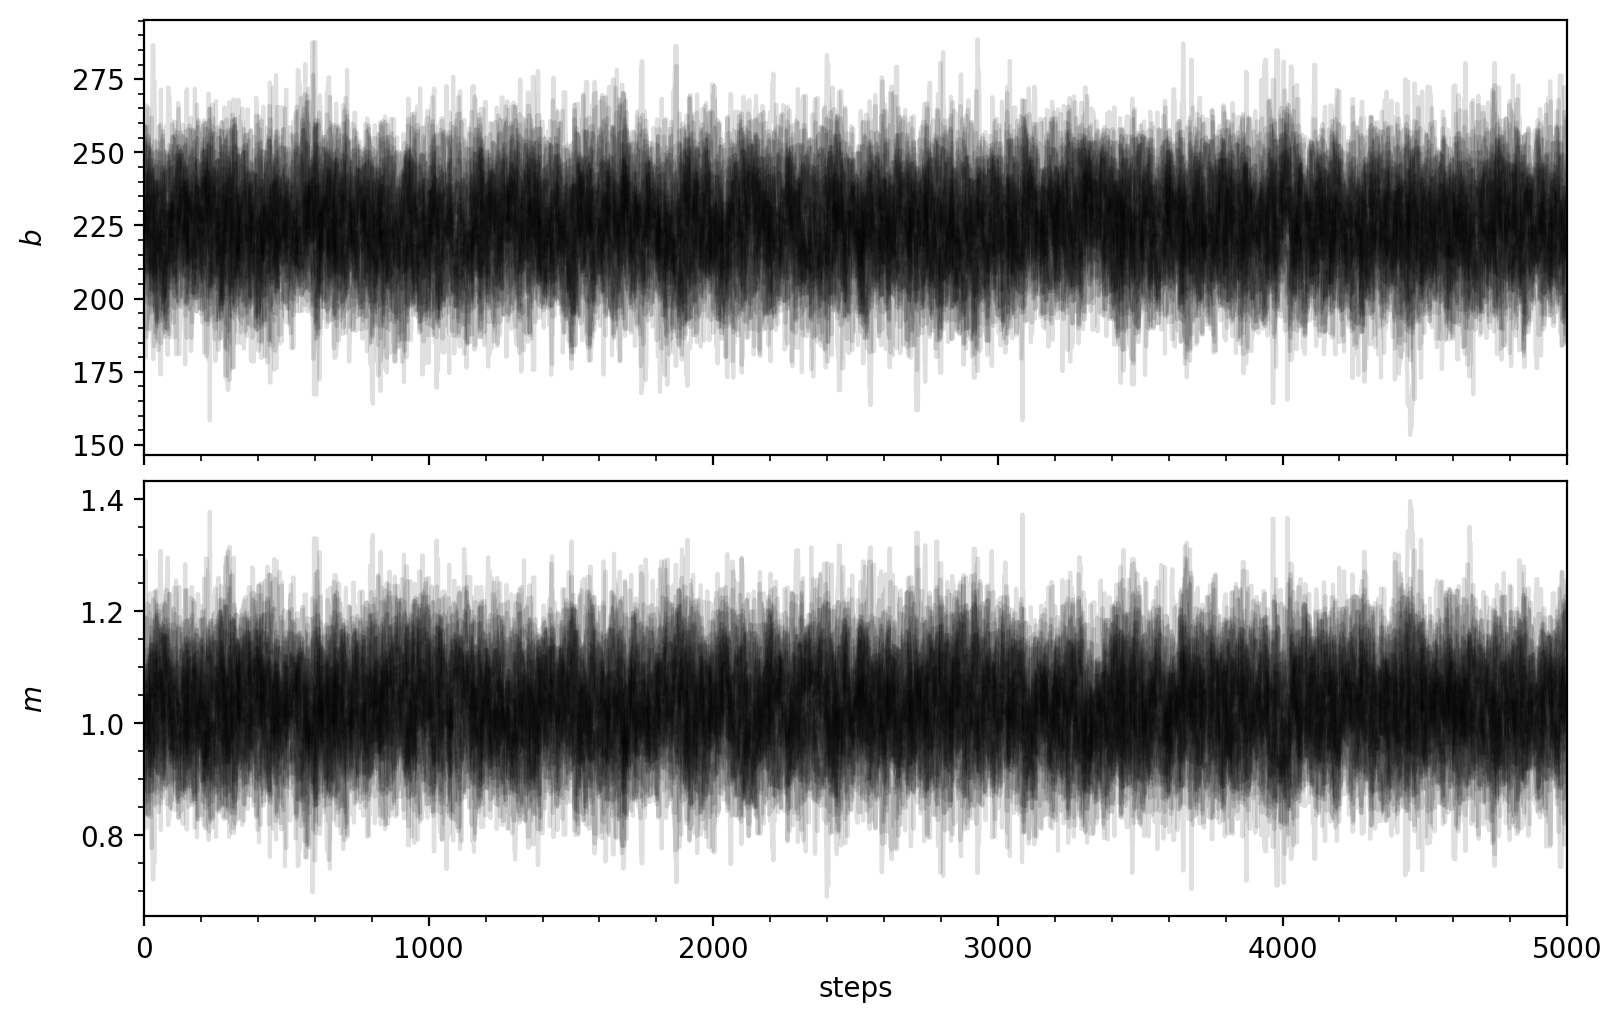

In [8]:
%config InlineBackend.figure_formats = ['retina']

# Burnt Walkers
fig, axes = plt.subplots(2, figsize=(8, 5), sharex=True)

samples = sampler.get_chain()
labels = [r"$b$", r"$m$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.125)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.0675, 0.5)

axes[-1].set_xlabel("steps");

plt.show()
plt.close()

%config InlineBackend.figure_formats = ['svg']

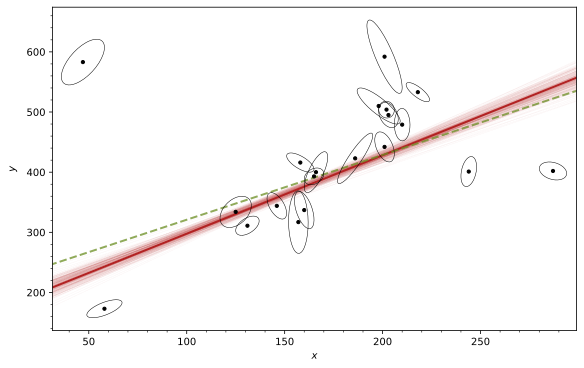

In [9]:
# Calculate Covariances
covs = np.array([[[x_e**2, x_e*y_e*rho], [x_e*y_e*rho, y_e**2]] for y_e, x_e, rho in zip(y_err, x_err, rho_xy)])

def ln_prior(theta):
    b, m = theta
    return -3/2 * np.log(1 + m**2)

def ln_likelihood(theta, x, y, C):
    b, m = theta

    V = np.array([[-m, 1]]).T

    Delta = (y - m * x - b)
    Sigma = (V.T @ C @ V).flatten()

    return np.sum(-np.log(Sigma) - 0.5 * Delta**2 / Sigma)

def ln_probability(theta, x, y, C):
    return ln_prior(theta) + ln_likelihood(theta, x, y, C)

neg_log_prob = lambda *args: -ln_probability(*args)

initial_theta = X.T[0]
args = (x, y, covs)

result = op.minimize(neg_log_prob, initial_theta, args=args, method="L-BFGS-B")

# Prepare Plot
l = np.array([-100, 400])

fig, ax = plt.subplots()

for xi, yi, cov in zip(x, y, covs):
    ax.add_artist(_ellipse(xi, yi, cov))

ax.plot(x, y, 'k.', ms=6.42)

ax.set_ylim(0.9 * ax.set_ylim()[0], 1.1 * ax.set_ylim()[1])
ax.set_xlim(0.9 * ax.set_xlim()[0], ax.set_xlim()[1])

ax.plot(l, initial_theta[1] * l + initial_theta[0], '--', alpha=0.75, lw=2, zorder=-1)
ax.plot([])
ax.plot(l, result.x[1] * l + result.x[0], lw=2, zorder=-2)

ax.set_ylabel(r'$y$')
ax.set_xlabel(r'$x$')

ax.yaxis.set_label_coords(-0.0675, 0.5)

# Sample Distribution
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * rng.standard_normal(ndim) for k in range(nwalkers)]

sampler = mc.EnsembleSampler(nwalkers, ndim, ln_probability,args=args)

pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

sampler.run_mcmc(pos, 5000)

chain = sampler.chain.reshape((-1, ndim))

for index in rng.choice(chain.shape[0], size=256):
    b, m = chain[index]
    ax.plot(l, m * l + b, c="firebrick", alpha=0.05, lw=0.5, zorder=-3)

plt.show()
plt.close()

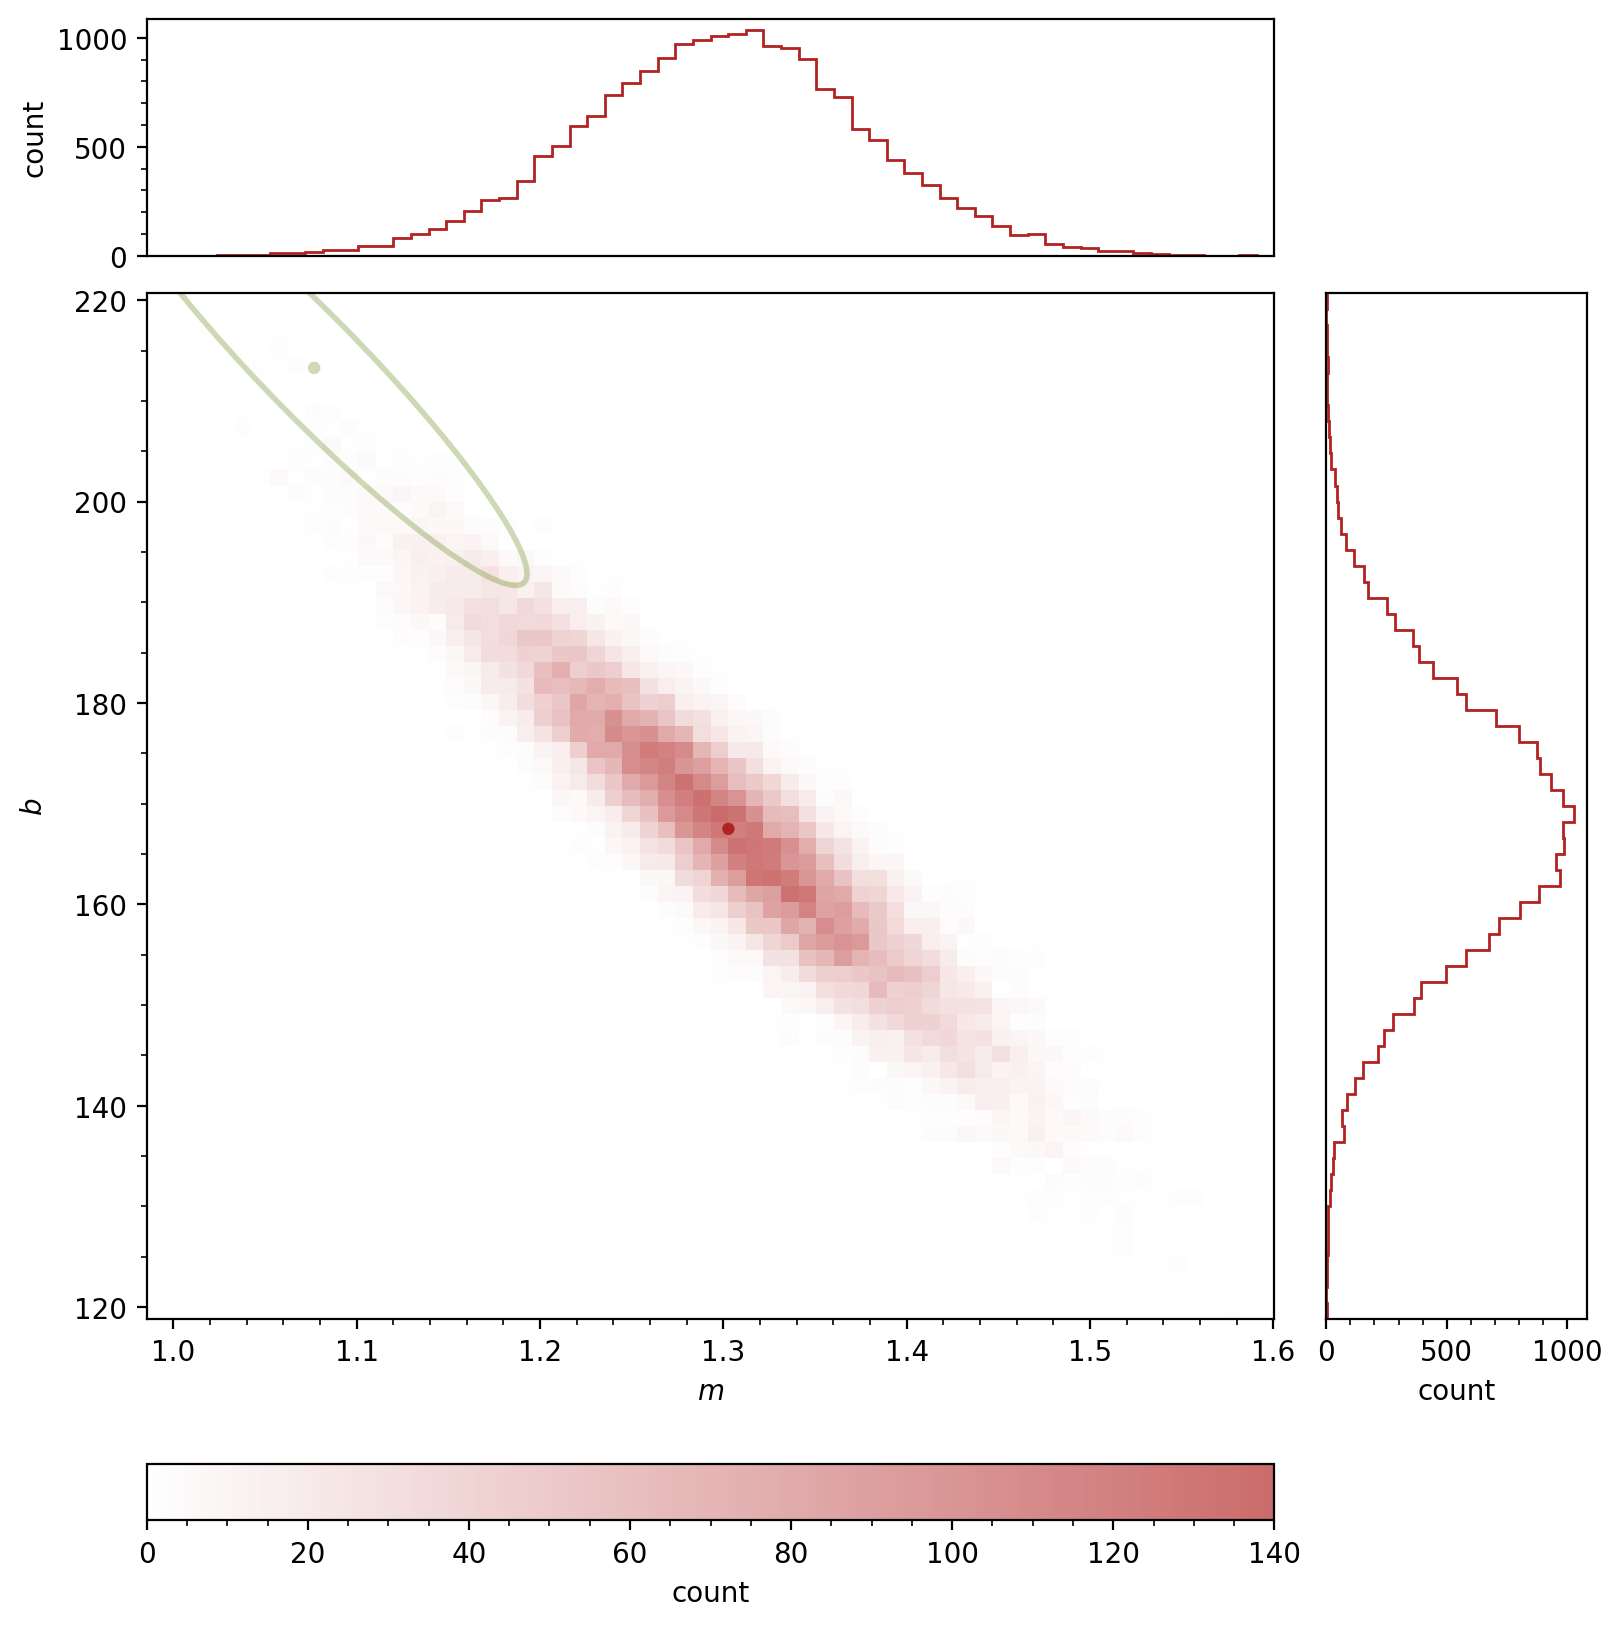

In [10]:
%config InlineBackend.figure_formats = ['retina']

# Main Plot
flat_samples = sampler.get_chain(thin=8, flat=True)

fig, ax = plt.subplots(2, 2, figsize=(8, 8), height_ratios=[1.5, 6.5], width_ratios=[6.5, 1.5])

hist = ax[1, 0].hist2d(flat_samples[:,1], flat_samples[:,0], bins=64, cmap=FireBrick_r, alpha=2/3)

ax[1, 0].scatter(result.x[1], result.x[0], 20, marker='o', facecolor="firebrick", edgecolor="none")

ax[1, 0].scatter(X[1], X[0], 20, marker='o', facecolor="olivedrab", edgecolor="none", alpha=1/3)
ax[1, 0].add_artist(_ellipse(X[1], X[0], G[::-1, ::-1], scale=3, color="olivedrab", lw=2, alpha=1/3))

cb = plt.colorbar(hist[3], location='bottom')
cb.set_label("count")

ax[1, 0].set_ylabel(r'$b$')
ax[1, 0].set_xlabel(r'$m$')

ax[1, 0].yaxis.set_label_coords(-0.0875, 0.5)

xlim = ax[1, 0].set_xlim()
ylim = ax[1, 0].set_ylim()

# Hidden Plot
ax[0, 1].axis('off')

# Top Plot
ax[0, 0].hist(flat_samples[:,1], bins=64, histtype='step', color="firebrick")

ax[0, 0].set_xlim(xlim)
ax[0, 0].get_xaxis().set_ticks([])

ax[0, 0].set_ylabel("count")
ax[0, 0].yaxis.set_label_coords(-0.0875, 0.5)

# Right Plot
ax[1, 1].hist(flat_samples[:,0], bins=64, histtype='step', orientation="horizontal", color="firebrick")

ax[1, 1].set_ylim(ylim)
ax[1, 1].get_yaxis().set_ticks([])

ax[1, 1].set_xlabel("count")

plt.show()
plt.close()

%config InlineBackend.figure_formats = ['svg']

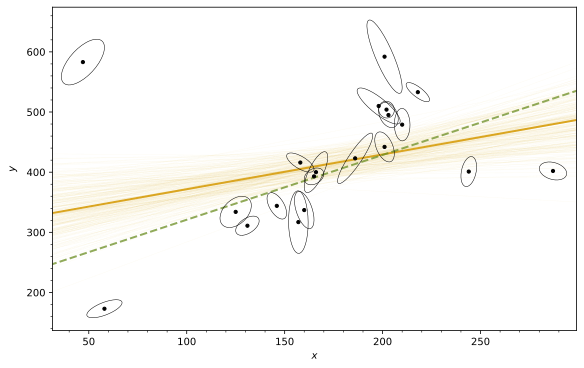

In [11]:
# Compute Probabilities
def ln_prior(theta):
    b, m, ln_lambda = theta
    if ln_lambda > 10 or ln_lambda < -10:
        return -np.inf
    return -3/2 * np.log(1 + m**2)

def ln_likelihood(theta, x, y, C):
    b, m, ln_lambda = theta
    
    V = np.array([[-m, 1]]).T

    intrinsic_variance = np.exp(ln_lambda)**2
    Lambda = (intrinsic_variance / (1 + m**2)) * np.array([[m**2, -m], [-m, 1]])

    Delta = (y - m * x - b)
    Sigma = (V.T @ (C + Lambda) @ V).flatten()

    return np.sum(-np.log(Sigma) - 0.5 * Delta**2 / Sigma)

def ln_probability(theta, x, y, C):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return lp
    return lp + ln_likelihood(theta, x, y, C)

neg_log_prob = lambda *args: -ln_probability(*args)

args = (x, y, covs)
initial_theta = np.hstack([X.T[0], -3])

result = op.minimize(neg_log_prob, initial_theta, args=args, method="L-BFGS-B", bounds=[(None, None), (None, None), (-10, 10)])

# Prepare Plot
l = np.array([-100, 400])

fig, ax = plt.subplots()

for xi, yi, cov in zip(x, y, covs):
    ax.add_artist(_ellipse(xi, yi, cov))

ax.plot(x, y, 'k.', ms=6.42)

ax.set_ylim(0.9 * ax.set_ylim()[0], 1.1 * ax.set_ylim()[1])
ax.set_xlim(0.9 * ax.set_xlim()[0], ax.set_xlim()[1])

ax.plot(l, initial_theta[1] * l + initial_theta[0], '--', alpha=0.75, lw=2, zorder=-1)
ax.plot([])
ax.plot([])
ax.plot(l, result.x[1] * l + result.x[0], lw=2, zorder=-2)

ax.set_ylabel(r'$y$')
ax.set_xlabel(r'$x$')

ax.yaxis.set_label_coords(-0.0675, 0.5)

# Sample Distribution
ndim, nwalkers = (result.x.size, 32)
p0 = [result.x + 1e-5 * rng.standard_normal(ndim) for k in range(nwalkers)]

sampler = mc.EnsembleSampler(nwalkers, ndim, ln_probability,args=args)

pos, *_ = sampler.run_mcmc(p0, 500)
sampler.reset()

sampler.run_mcmc(pos, 5000)

chain = sampler.chain.reshape((-1, ndim))

for index in rng.choice(chain.shape[0], size=256):
    b, m, ln_lambda = chain[index]
    ax.plot(l, m * l + b, c="goldenrod", alpha=0.05, lw=0.5, zorder=-3)

plt.show()
plt.close()

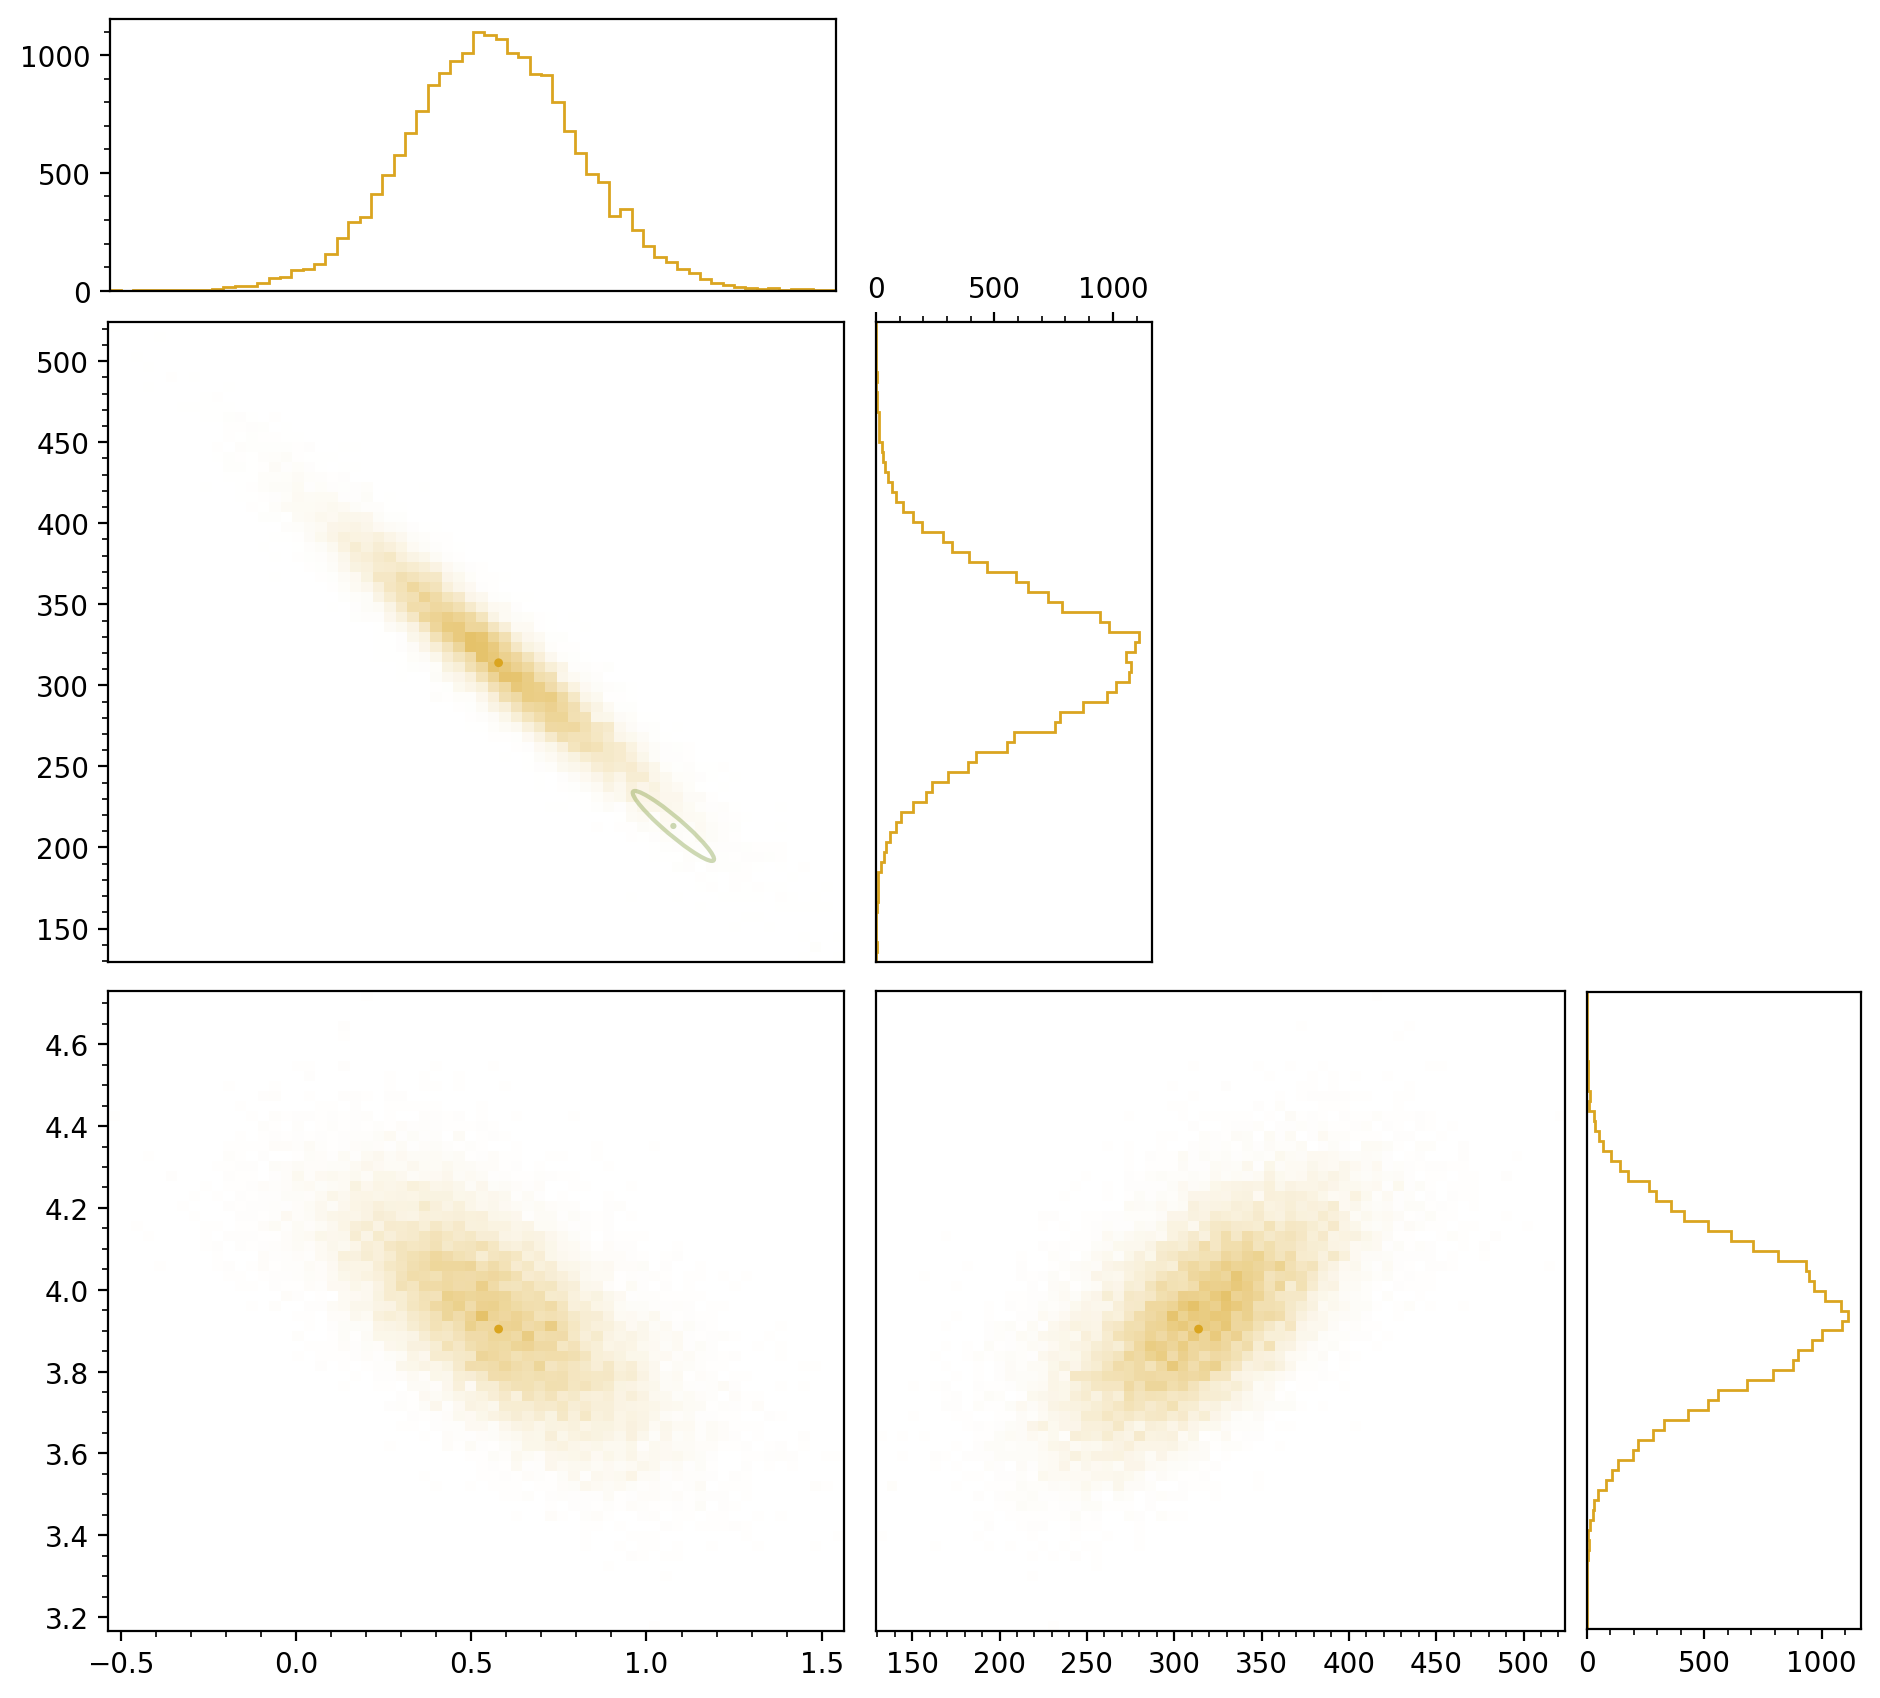

In [12]:
%config InlineBackend.figure_formats = ['retina']

# Main Plot
flat_samples = sampler.get_chain(thin=8, flat=True)

#fig, ax = plt.subplots(3, 3, figsize=(9, 9), height_ratios=[1.5, 3.5, 3.5], width_ratios=[3.5, 3.5, 1.5])

fig = plt.figure(figsize=(9.125, 8.5))

gs = plt.GridSpec(3, 4, figure=fig, height_ratios=[1.5, 3.5, 3.5], width_ratios=[4, 1.5, 2.125, 1.5], hspace=0.05, wspace=0.05)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1:3])
ax6 = fig.add_subplot(gs[2, 3])

# Plot (m,b)
ax2.hist2d(flat_samples[:,1], flat_samples[:,0], bins=64, cmap=GoldenRod_r, alpha=2/3)

lim_1 = ax2.set_xlim()
lim_0 = ax2.set_ylim()

ax2.get_xaxis().set_ticks([])

ax2.scatter(result.x[1], result.x[0], 10, marker='o', facecolor="goldenrod", edgecolor="none")

ax2.scatter(X[1], X[0], 5, marker='o', facecolor="olivedrab", edgecolor="none", alpha=1/3)
ax2.add_artist(_ellipse(X[1], X[0], G[::-1, ::-1], scale=3, color="olivedrab", lw=1.5, alpha=1/3))

# Plot (m,lam)
ax4.hist2d(flat_samples[:,1], flat_samples[:,2], bins=64, cmap=GoldenRod_r, alpha=2/3)

lim_2 = ax4.set_ylim()

ax4.scatter(result.x[1], result.x[2], 10, marker='o', facecolor="goldenrod", edgecolor="none")

# Plot (b,lam)
ax5.hist2d(flat_samples[:,0], flat_samples[:,2], bins=64, cmap=GoldenRod_r, alpha=2/3)

ax5.get_yaxis().set_ticks([])

ax5.scatter(result.x[0], result.x[2], 10, marker='o', facecolor="goldenrod", edgecolor="none")

# Plot (m)
ax1.hist(flat_samples[:,1], bins=64, histtype='step', color="goldenrod")

ax1.set_xlim(lim_1)
ax1.get_xaxis().set_ticks([])

pos1 = ax1.get_position()
ax1.set_position([pos1.x0 - 0.0800, pos1.y0 + 0.0725, 1.2150 * pos1.width, 1.2150 * pos1.height])

# Plot (b)
ax3.hist(flat_samples[:,0], bins=64, histtype='step', orientation="horizontal", color="goldenrod")

ax3.set_ylim(lim_0)
ax3.get_yaxis().set_ticks([])
ax3.xaxis.tick_top()

# Plot (lam)
ax6.hist(flat_samples[:,2], bins=64, histtype='step', orientation="horizontal", color="goldenrod")

ax6.set_ylim(lim_2)
ax6.get_yaxis().set_ticks([])

pos6 = ax6.get_position()
ax6.set_position([pos6.x0 + 0.0770, pos6.y0 - 0.0765, 1.2225 * pos6.width, 1.2225 * pos6.height])






#ax[1, 0].scatter(result.x[1], result.x[0], 20, marker='o', facecolor="firebrick", edgecolor="none")

#ax[1, 0].scatter(X[1], X[0], 20, marker='o', facecolor="olivedrab", edgecolor="none", alpha=1/3)
#ax[1, 0].add_artist(_ellipse(X[1], X[0], G[::-1, ::-1], scale=3, color="olivedrab", lw=2, alpha=1/3))

#cb = plt.colorbar(hist[3], location='bottom')
#cb.set_label("count")

#ax[1, 0].set_ylabel(r'$b$')
#ax[1, 0].set_xlabel(r'$m$')

#ax[1, 0].yaxis.set_label_coords(-0.0875, 0.5)

#xlim = ax[1, 0].set_xlim()
#ylim = ax[1, 0].set_ylim()

# Hidden Plot
#ax[0, 1].axis('off')
#ax[0, 2].axis('off')
#ax[1, 2].axis('off')

# Top Plot
#ax[0, 0].hist(flat_samples[:,1], bins=64, histtype='step', color="firebrick")

#ax[0, 0].set_xlim(xlim)
#ax[0, 0].get_xaxis().set_ticks([])

#ax[0, 0].set_ylabel("count")
#ax[0, 0].yaxis.set_label_coords(-0.0875, 0.5)

# Right Plot
#ax[1, 1].hist(flat_samples[:,0], bins=64, histtype='step', orientation="horizontal", color="firebrick")

#ax[1, 1].set_ylim(ylim)
#ax[1, 1].get_yaxis().set_ticks([])

#ax[1, 1].set_xlabel("count")

plt.show()
plt.close()

%config InlineBackend.figure_formats = ['svg']